# Project Title: An In-Depth Time Series Approach for Dynamic Sales Forecasting

## 1. Importing Libraries

In [ ]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= 'darkgrid')

#some built in functions
import itertools
from datetime import datetime, timedelta

import warnings
#to supress warning generated for fb prophet using .append method by default
# warnings.simplefilter(action='ignore', category=FutureWarning) 
#to suppress warnings in Sarima model
# warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

#importing high level interactive plotting libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# importing time series stats model
import statsmodels.api as sm
from statsmodels.api import tsa 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#importing Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

#sklearn library
from sklearn.preprocessing import MinMaxScaler

#importing fb prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly

#importing XG Boost 
import xgboost as xgb
from xgboost import plot_importance, plot_tree



In [68]:
import plotly.io as pio
pio.renderers.default= "svg"


## 2. Importing Data

In [69]:
# Loading the dataset
df = pd.read_csv("../data/master_dataaa.csv") 

# Reading the head
df.head()


,order_id,customer_id,order_purchase_timestamp,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_id,seller_city,seller_state,price,freight_value,qty,total_amount
0,18bb4acb90913593d37049c601660009,591cb16ea1a6d8f7eebd0a349593bea2,5/1/2018 9:25,6/7/2018 0:00,0019e8c501c85848ac0966d45226fa1d,cuiaba,MT,1dfb36d969d347f56f43590ec42c7b8c,50,1212,5,900,26,6,13,7f152321c60a266edc53af1925ef96c1,criciuma,SC,159.99,37.28,1,159.99
1,0c9f8646d592c21c2015b929996427af,493941e03992cc140b88be7a292808c9,3/20/2018 7:44,4/16/2018 0:00,beac646283545df90be6dbf8b17668b7,feira de santana,BA,d3f4f3de0f4576184674937d1e9cecca,51,122,4,450,20,31,30,3d871de0142ce09b7081e2b9d1733cb1,campo limpo paulista,SP,34.90,22.06,1,34.90
2,211635839640ec89714ed4410c5d9eea,39ea5fecfa8dd33f8dc7abb45fb29d82,5/27/2018 16:00,6/20/2018 0:00,faedbbe182b58bf796b021a37fe5a5f0,sao paulo,SP,52e5fdcb5e51164483d584c75bd3a478,55,211,1,150,19,8,16,92eb0f42c21942b6552362b9b114707d,sao paulo,SP,25.77,7.39,1,25.77
3,158263d44a3e5ae322126338c7776dea,182dc723d820aae1a351f75ab1f53451,1/5/2018 9:35,1/30/2018 0:00,b5bd39235b4e377d8a64f37f82ed93f0,rio novo,MG,c93558f621dc5b9277a19f009b83aaaf,38,1145,2,200,21,8,11,3fe7120d6257285ac6a3ce7cb071ccec,governador valadares,MG,99.99,12.83,1,99.99
4,1fa5ff94927b15bd84bba43684f8fa6e,aa6d96d0e25354fab970635297f96f7c,8/11/2017 13:30,9/6/2017 0:00,88ed5da9b610ed59feb01e4eed5e4c2c,nuporanga,SP,bc2d6310e5cbd60facb2f9c8d9471597,23,779,2,7100,36,47,32,dc317f341ab0e22f39acbd9dbf9b4a1f,cachoeirinha,RS,629.00,41.92,1,629.00


In [70]:
# Understanding the datatypes
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       1000 non-null   object 
 1   customer_id                    1000 non-null   object 
 2   order_purchase_timestamp       1000 non-null   object 
 3   order_estimated_delivery_date  1000 non-null   object 
 4   customer_unique_id             1000 non-null   object 
 5   customer_city                  1000 non-null   object 
 6   customer_state                 1000 non-null   object 
 7   product_id                     1000 non-null   object 
 8   product_name_lenght            1000 non-null   int64  
 9   product_description_lenght     1000 non-null   int64  
 10  product_photos_qty             1000 non-null   int64  
 11  product_weight_g               1000 non-null   int64  
 12  product_length_cm              1000 non-null   in

In [71]:
# Checking if there are any null values
df.isnull().sum()


order_id                         0
customer_id                      0
order_purchase_timestamp         0
order_estimated_delivery_date    0
customer_unique_id               0
customer_city                    0
customer_state                   0
product_id                       0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_id                        0
seller_city                      0
seller_state                     0
price                            0
freight_value                    0
qty                              0
total_amount                     0
dtype: int64

In [72]:
print(f" The number of unique orders : {df['order_id'].nunique()}")
print(f" The number of unique customers : {df['customer_unique_id'].nunique()}")
print(f" The total number of customer transactions specified by customer ids :  {df['customer_id'].nunique()}")
print(f" Overall {round((df['customer_unique_id'].nunique()/df['customer_id'].nunique())*100, 2)} % transcations \
are made by new customers and {round((1 -(df['customer_unique_id'].nunique()/df['customer_id'].nunique()))*100,2)} % \
are made by repeat customers.")
print(f" The number of unique sellers {df['seller_id'].nunique()}")
print(f" The number of unique products sold at Olist platform {df['product_id'].nunique()}")

 The number of unique orders : 891
 The number of unique customers : 891
 The total number of customer transactions specified by customer ids :  891
 Overall 100.0 % transcations are made by new customers and 0.0 % are made by repeat customers.
 The number of unique sellers 455
 The number of unique products sold at Olist platform 794


### 2.1 Data dictionary
- order_id : Specifies the unique order. We have 95832 unique orders. Of 110K rows an order_id can reappear in the- dataframe but it will have another product category and number of items bought in that category.
- customer_id: Specifies the customer id for the order. We have a customer ids associated with each order. There are a total of 95832 unique customer ids.
- order_purchase_timestamp : The time stamp for the order. It includes date and time.
- order_estimated_delivery_date : Estimated delivery date at the time of purchase.
- product_id : This specify the actual product in a product category. We have 32072 unique products within 74 overall product categories.
- seller_id : We have 2965 unique sellers.

- freight_value : The freight charges based on product weight and dimension. This value is for one item. If there are three items the total freight will be equal to three times the freight_value.
- product_name_lenght : Number of characters extracted from the product name.
- product_description_lenght : Number of characters extracted from the product description.
- product_photos_qty : Number of product published photos.
- product_weight_g : Product weight measured in grams.
- product_length_cm : Product length measured in centimeters.
- product_height_cm : Product height measured in centimeters.
- product_width_cm : Product width measured in centimeters.
- seller_city : It is the city where seller is located.
- seller_state : It is the state where seller is located.
- customer_unique_id : There are 92755 unique customers which make up 96.79 % of the total customers in database. Only 3.21% of the customers have made repeat purchase. It may be because the data we have is the initial data when Olist had just started its business and therefore we have all the new customers in the database.
- customer_city : It is the city where customer is located.
- customer_state : It is the state where customer is located.
- qty : Number of items bought in a product category.
- price : Unit price for each product.
Target Variable : total_amount : We have calculated this value after multiplying qty and price. This is the actual sales amount important for the business. We will be predicting sales amount to help business prepare for the the future.
- ```Target Variable``` : total_amount : We have calculated this value after multiplying qty and price. This is the actual sales amount important for the business. We will be predicting sales amount to help business prepare for the the future.

### 2.2 Processing Data for Time Series.

```order_purchase_timestamp``` has incorrect format column. Let's start converting this column to date-time format and  try to extract some features from dates for analysis.

In [73]:
#converting date columns which are in object format to datetime format
df['order_purchase_timestamp']=pd.to_datetime(df['order_purchase_timestamp'])

let's extract year, date, moth , weekday and day information from the dates.

In [74]:
#converting date columns which are in object format to datetime format
df['purchase_year']=pd.to_datetime(df['order_purchase_timestamp']).dt.year
df['purchase_month']=pd.to_datetime(df['order_purchase_timestamp']).dt.month
df['purchase_MMYYYY']=pd.to_datetime(df['order_purchase_timestamp']).dt.strftime('%m-%Y')
df['purchase_week']=pd.to_datetime(df['order_purchase_timestamp']).dt.isocalendar().week
df['purchase_dayofweek']=pd.to_datetime(df['order_purchase_timestamp']).dt.weekday
df['purchase_dayofmonth']=pd.to_datetime(df['order_purchase_timestamp']).dt.day

Aggregate the total_amount by dates so that we can get a time series, meaning a dataframe with the total_amount column arranged in order as per dates. Let's set the dates as index.

In [75]:
# Creating new DataFrame with daily frequency and number of orders
df_agg = df.groupby(pd.Grouper(key='order_purchase_timestamp', freq='D'))['total_amount'].sum().reset_index()
df_agg.set_index('order_purchase_timestamp', inplace=True)
df_agg.index.freq = 'D' # To keep pandas inference in check!

#reading top five rows
print(df_agg.head())

# checking the mean, max and count values.
print(df_agg.describe())

                          total_amount
order_purchase_timestamp              
2016-10-07                        69.9
2016-10-08                         0.0
2016-10-09                         0.0
2016-10-10                         0.0
2016-10-11                         0.0
       total_amount
count    691.000000
mean     198.193792
std      359.953370
min        0.000000
25%        0.000000
50%       65.000000
75%      254.140000
max     3472.330000


In [76]:
#checking the info
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 691 entries, 2016-10-07 to 2018-08-28
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_amount  691 non-null    float64
dtypes: float64(1)
memory usage: 10.8 KB


In [77]:
#checking head
df_agg.head()

,total_amount
order_purchase_timestamp,
2016-10-07,69.9
2016-10-08,0.0
2016-10-09,0.0
2016-10-10,0.0
2016-10-11,0.0


In [78]:
#index start
df_agg.head(1).index

DatetimeIndex(['2016-10-07'], dtype='datetime64[ns]', name='order_purchase_timestamp', freq='D')

In [79]:
#index end
df_agg.tail(1).index

DatetimeIndex(['2018-08-28'], dtype='datetime64[ns]', name='order_purchase_timestamp', freq='D')

We have a total of 691 observations staring form '2016-09-15' till '2018-08-29'.

## 3. Explorartory Data Analysis
Let's explore some high level features of our master data and will go a level deeper for our time series.

### 3.1 General exploration

heat map to see which numerical features are highly correlated with the total_amount. This is just a high level overview to see which features can impact sales and also the correlation among the features.

<Axes: >

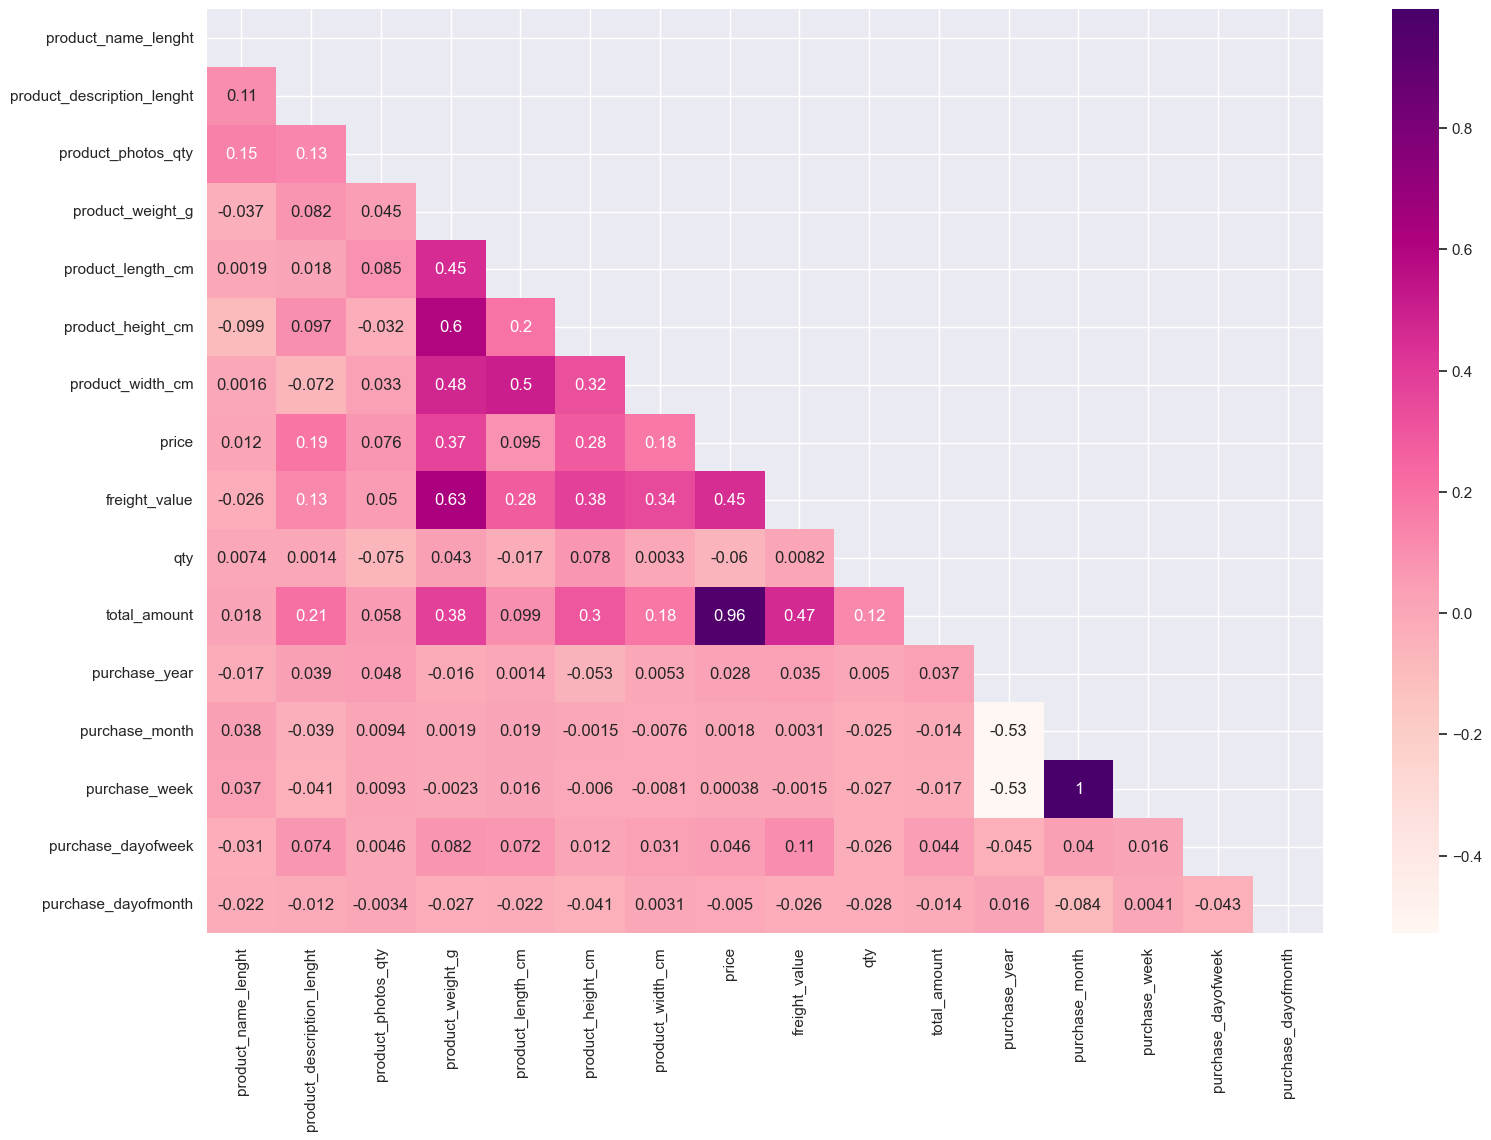

In [80]:
#canvas size
plt.figure(figsize=(18,12))
#correlation between all columns
corr_df= df.select_dtypes(include=np.number).corr()
# creating mask
mask = np.triu(np.ones_like(corr_df.corr()))
# plotting a triangle correlation heatmap
sns.heatmap(corr_df, cmap="RdPu", annot=True, mask=mask) 

#### Observations
- Price shows the strongest positive correlation with total sales amount.

- Freight value has a moderate positive relationship with total amount, indicating higher shipping cost for higher-value items.

- Product dimensions (length, height, width) are moderately correlated with freight value.

- Quantity shows only a weak correlation with total amount, suggesting most orders contain single units.

- Date-related features (year, month, week, day) have very weak correlations, indicating no strong linear time-based influence.


We will plot the histogram to see the distribution of total_amount.

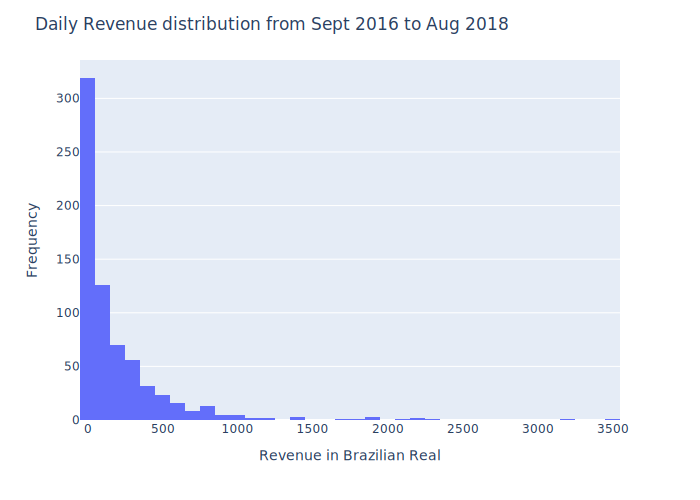

In [81]:
#importing high level interactive plotting libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "svg"

#had to install orca to publish static images of plotly graph on git hub as plotly plots were not showing up.
# installed using conda install -c plotly plotly-orca and had to manually assign the path to orca exe.

fig=px.histogram(df_agg, x='total_amount')
fig.update_layout(
    yaxis_title="Frequency",
    xaxis_title="Revenue in Brazilian Real",
    legend_title="", 
    title="Daily Revenue distribution from Sept 2016 to Aug 2018")
# fig.show()
fig.show("svg")

The daily revenue distribution is highly right-skewed, with most days generating low to moderate sales and only a few days showing very high revenue spikes. This indicates high variability and the presence of outlier sales days.

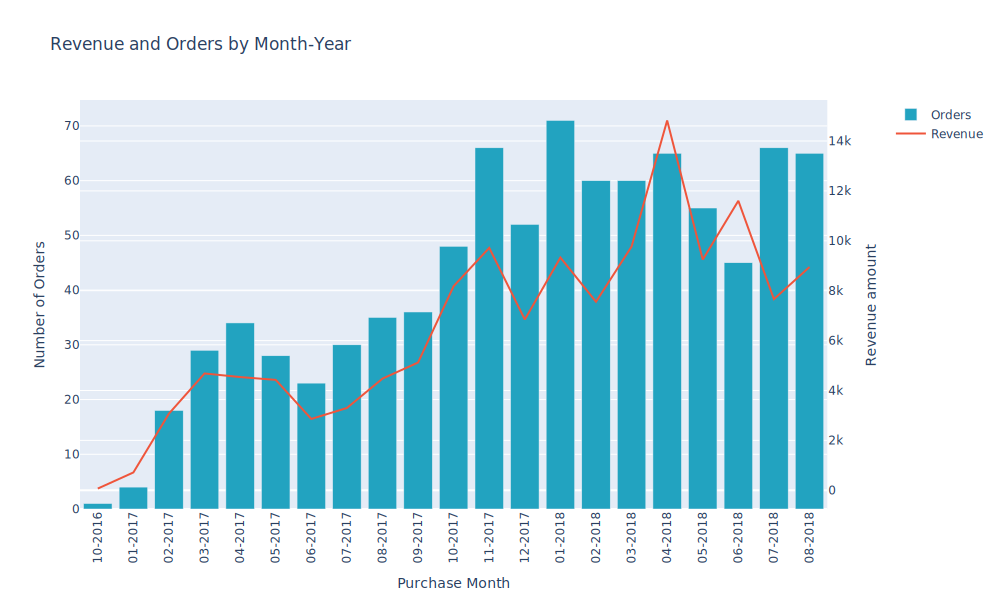

In [82]:
#we are creating pivot table with three index year, month and string MMYYY and getting sum of total_amount and number of orders
sales_df=df.pivot_table(values = ['order_id', 'total_amount']
                              , index=['purchase_year','purchase_month','purchase_MMYYYY']
                              , aggfunc={'order_id':'nunique', 'total_amount':'sum'})
from plotly.subplots import make_subplots

#to plot number of orders by MMYYY
trace1 = go.Bar(
    x=sales_df.index.get_level_values(2),
    y=sales_df['order_id'],
    name='Orders',
    marker=dict(
        color='rgb(34,163,192)'
               )
)
#to plot sum of total_amounts by MMYYY
trace2 = go.Scatter(
    x=sales_df.index.get_level_values(2),
    y=sales_df['total_amount'],
    name='Revenue',
    yaxis='y2' #using a right side y-axis

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 600, width = 1000, title = 'Revenue and Orders by Month-Year',xaxis=dict(
      tickangle=-90, title='Purchase Month'), yaxis=dict(title= 'Number of Orders'), yaxis2=dict(title= 'Revenue amount'))
# fig.show()
fig.show("svg")

**Observations:**
- Both orders and revenue show a clear upward trend from late 2016 to mid-2018.

- Peak activity occurs around early 2018, with the highest revenue observed in April 2018.

- Order volume generally increases over time, with several strong months in late 2017 and throughout 2018.

- Revenue fluctuations are sharper than order counts, indicating varying average order values.

- Overall, the business shows consistent growth, with higher monthly sales and revenue toward the end of the period.

In [83]:
print(f"The overall revenue earned as of Aug 2018 is {df_agg['total_amount'].sum()} Brazilian Real.")

The overall revenue earned as of Aug 2018 is 136951.91 Brazilian Real.


Let's check what is the overall revenue for each year and what is year over year growth from 2016 to 2017 and 2017 to 2018.

In [84]:
#checking the sale made in each year
df_agg.groupby(df_agg.index.year).sum()

,total_amount
order_purchase_timestamp,
2016,69.90
2017,57940.78
2018,78941.23


In [85]:
print(f'The year over year growth from 2016 to 2017 is {6722987.98/45756.84 - 1}')

The year over year growth from 2016 to 2017 is 145.9285899113663


In [86]:
print(f'The year over year growth from 2017 to 2018 is {(8140605.72/6722987.98)-1}')

The year over year growth from 2017 to 2018 is 0.21086126350623036


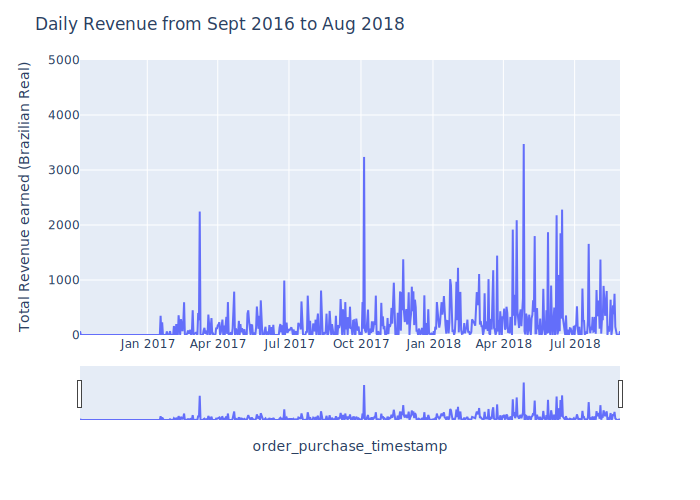

In [87]:
#plotting daily data to get high level picture

fig = px.line(df_agg, x=df_agg.index, y='total_amount')

# axis labels and title
fig.update_layout(
    yaxis_title="Total Revenue earned (Brazilian Real)", 
    legend_title="", 
    title="Daily Revenue from Sept 2016 to Aug 2018"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

#annotate peak
fig.add_annotation(x='2017-11-24', y= 184834.17, text=f'Black Friday Sale', yanchor='bottom', 
                   showarrow=True, arrowhead=1, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
                   ax=-20, ay=-30, font=dict(size=15, color="green", family="Courier New, monospace"),
                   align="left", bordercolor="green", borderwidth=2, bgcolor="#CFECEC", opacity=0.8)

fig.update_yaxes(range=[0, 5000])


# fig.show()
fig.show("svg")


Daily revenue shows high volatility with occasional large spikes, but the overall trend steadily increases from 2016 to 2018, indicating consistent business growth over time.

#### Removing the observations before Jan 1 2017
- Removing the data before Jan 01 2017 because there are a lot of consecutive days with zero sales.
- It may be because the period of Sept 2016 to Dec 2016 was an experimental phase.
- Including them in our model may impact our forecasting. We can find that we have continuous sales after Jan 2017.

In [88]:
#removing the rows before Jan 01 2017
daily_data=df_agg.loc[df_agg.index>='2017-01-01', :]

In [89]:
daily_data.tail()

,total_amount
order_purchase_timestamp,
2018-08-24,0.0
2018-08-25,0.0
2018-08-26,0.0
2018-08-27,0.0
2018-08-28,69.0


In [90]:
print(f"The total number of datapoint to work on :{daily_data.shape[0]}")

The total number of datapoint to work on :605


In [91]:
#saving the start and end dates separately
start_date=daily_data.index[0]
end_date=daily_data.index[-1]


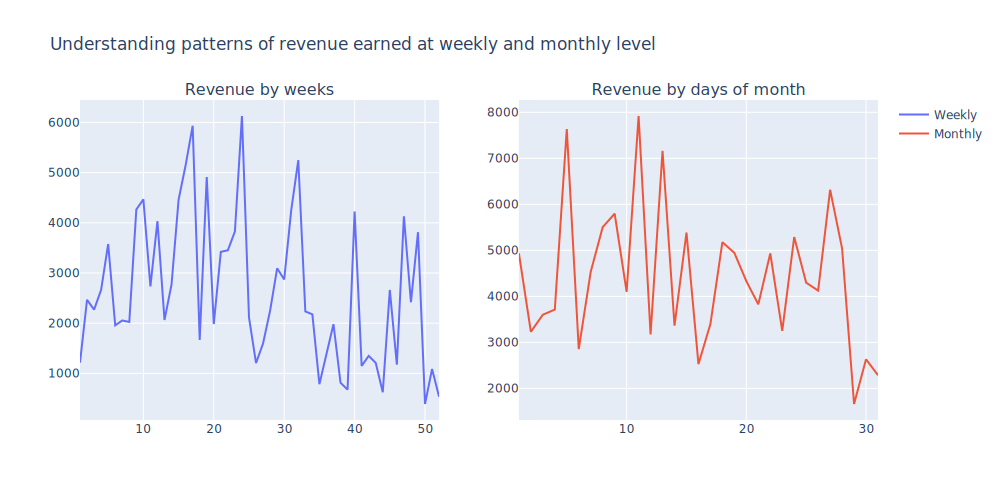

In [92]:
df1=df.groupby('purchase_week')['total_amount'].sum()
df2=df.groupby('purchase_dayofmonth')['total_amount'].sum()

fig=make_subplots(rows=1, cols=2, subplot_titles=("Revenue by weeks", "Revenue by days of month"))

fig.add_trace(go.Scatter(name='Weekly', x=df1.index, y=df1.values), row=1, col=1 )

fig.add_trace(go.Scatter(name='Monthly', x=df2.index, y=df2.values), row=1, col=2 )

fig.update_layout(height=500, width=1000,
                  title_text="Understanding patterns of revenue earned at weekly and monthly level")

# fig.show()
fig.show("svg")

### 3.2 Decomposing time series
We will be decomposing the time series using additive decomposition so that we can observe the underlying trend, seasonality and residuals.


Additive Decomposition : Trend + Seasonality + Residual

In [93]:
# importing time series stats model
import statsmodels.api as sm
from statsmodels.api import tsa 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# decompose the time series
decomposition = tsa.seasonal_decompose(daily_data, model='additive')

In [94]:
#saving copy to new datafrme
daily_df=daily_data.copy()

In [95]:
# add the decomposition data
daily_df['Trend'] = decomposition.trend
daily_df['Seasonal'] = decomposition.seasonal
daily_df['Residual'] = decomposition.resid

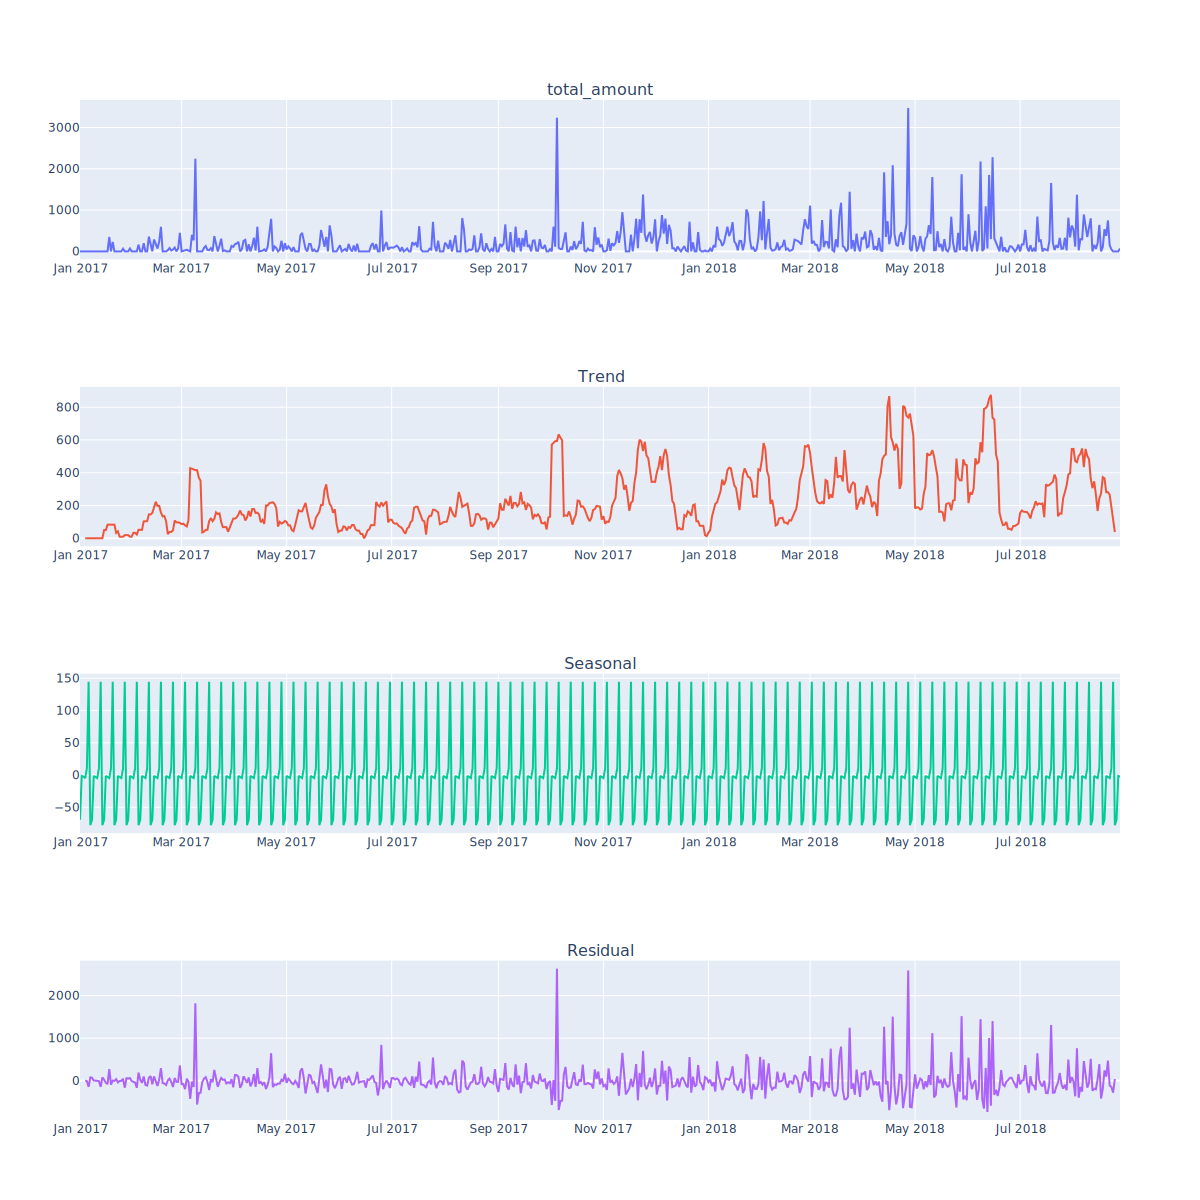

In [96]:
#plotting the actual and decomposed componenets of time series
cols = ["total_amount","Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=4, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=daily_df.index, y=daily_df[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=1200, width=1200, showlegend=False)
# fig.show()
fig.show("svg")

- Trend component shows a steady upward movement, indicating consistent growth in daily revenue over time.

- Seasonal component is strong and repetitive, suggesting clear recurring daily or weekly patterns in sales.

- Residual component captures irregular spikes, reflecting unexpected high-revenue days or one-off events.

- The original series aligns well with the trend + seasonality, confirming that the data has structured patterns.

- High residual variability in 2018 suggests increasing unpredictability alongside business growth.

### 3.3 Checking stationarity


Forecasting assumes that historical patterns will continue into the future. For this reason, it is important for a time series to be stationary. If the data’s statistical properties change over time, accurate forecasting becomes difficult. A stationary series has constant mean and variance, so we examine rolling mean and rolling standard deviation to visually assess whether the series is stationary.


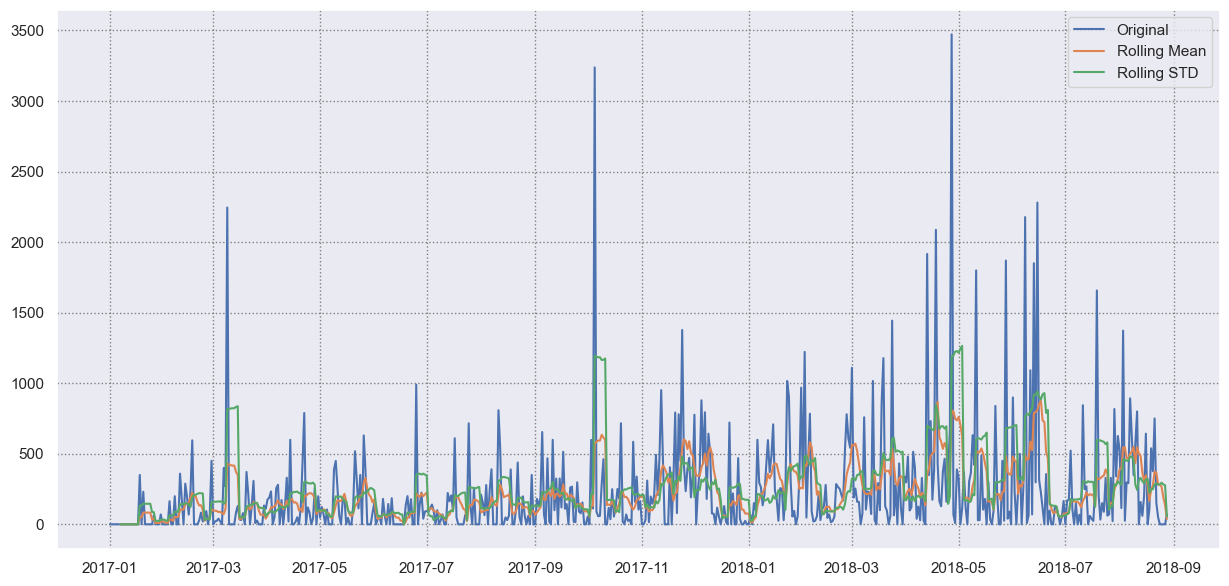

In [97]:
#plotting rolling mean and standard deviation.

# Get Things Rolling
roll_mean = daily_df['total_amount'].rolling(window=7).mean()
roll_std = daily_df['total_amount'].rolling(window=7).std()
    
# Figure
fig, ax = plt.subplots(figsize=(15,7), facecolor='w')
ax.plot(daily_df['total_amount'], label='Original')
ax.plot(roll_mean, label='Rolling Mean')
ax.plot(roll_std,  label='Rolling STD')
    
# Legend & Grid
ax.legend(loc='upper right')
plt.grid(linestyle=":", color='grey')
plt.show()

#### Key Observations

- Both the rolling mean and rolling standard deviation change over time, indicating the series is not stationary.

- Mean values gradually increase, reflecting growing sales activity rather than a stable long-term average.

- The standard deviation becomes larger in later periods, showing increased revenue volatility.

- Several sharp spikes in both metrics highlight irregular, high-revenue days that disrupt stability.

- Overall, the time series exhibits clear trends and variability, confirming the need for transformations before forecasting.


### Statistical tests to check stationarity
ADF - Augmented Dickey Fuller Test
ADF test is used to determine the presence of unit root in the series, the presence of a unit root means the time series is non-stationary. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary. The null and alternate hypothesis of this test are:


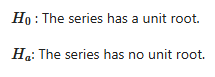

If the null hypothesis is failed to be rejected (the p-value obtained is greater than the significance level (say 0.05)), this test may provide evidence that the series is non-stationary.

#### KPSS - Kwiatkowski-Phillips-Schmidt-Shin
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

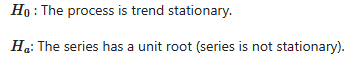

In [98]:
def perform_adf_test(df) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
        
    Returns: None
    """
    
    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)
    
    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

ADF and KPSS test on original Sales amount

In [99]:
print("ADF and KPSS test on original total_amount")
print("******************************************")
perform_adf_test(daily_df['total_amount'])
perform_kpss_test(daily_df['total_amount'])

ADF and KPSS test on original total_amount
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -4.306663
p-value: 0.000433
Number of lags used: 13
Number of observations used: 591
T values corresponding to adfuller test:
1% -3.4414632489439714
5% -2.866442840548375
10% -2.5693810879206143

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 2.281347
p-value: 0.010000
Number of lags used: 9
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739



**Observation and Findings**

ADF & KPSS Results on Original `total_amount` Time Series

* **ADF Test:**
  Since the ADF Statistic p-value **0.000433 < 0.05**, we reject the null hypothesis (H_0) in favor of the alternative (H_a).

* **KPSS Test:**
  Since the KPSS Statistic p-value **0.01 < 0.05**, we reject the null hypothesis (H_0) in favor of (H_a).



* **According to the ADF test, our series does not have a unit root**, meaning the series appears **stationary** based on ADF.
* **According to the KPSS test, the series is not trend-stationary**, indicating **non-stationarity** based on KPSS.

**Interpretation (from statsmodels guidance)**

When **KPSS indicates non-stationarity** and **ADF indicates stationarity**, the series is interpreted as **difference-stationary**.
This means **differencing is required** to make the series fully stationary.
We will proceed by differencing the time series and then re-checking its stationarity.


#### Differencing the time series
We will try to difference the series by differencing it with a previous day observation.

In [100]:
#differencing with previous day
daily_df["day_difference"] = daily_df["total_amount"].diff(1)

In [101]:
print("  ADF and KPSS test on differnced data  ")
print("******************************************")
perform_adf_test(daily_df["day_difference"].dropna())
perform_kpss_test(daily_df["day_difference"].dropna())

  ADF and KPSS test on differnced data  
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -12.392775
p-value: 0.000000
Number of lags used: 12
Number of observations used: 591
T values corresponding to adfuller test:
1% -3.4414632489439714
5% -2.866442840548375
10% -2.5693810879206143

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.080814
p-value: 0.100000
Number of lags used: 76
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739




**Observation and Findings**

**ADF & KPSS Results on Differenced `total_amount` Time Series**

* **ADF Test:**
  Since the ADF Statistic p-value **0.000000 < 0.05**, we reject the null hypothesis (H_0) and conclude that the differenced series is **stationary** according to ADF.

* **KPSS Test:**
  Since the KPSS Statistic p-value **0.10 > 0.05**, we fail to reject the null hypothesis (H_0).
  This means the differenced series is **trend-stationary** based on KPSS.



* **Both ADF and KPSS tests now indicate stationarity**.
* The series becomes **fully stationary after first differencing**, confirming that differencing successfully stabilized the mean and variance.

**Final Interpretation**

With both tests agreeing that the differenced series is stationary, the data is now suitable for *modeling and forecasting* using ARIMA, SARIMA, Prophet, or other time-series models.



## 4. Preparation for Modeling

We want to create some functions that we will call again and again. Hence we will be creating a test and tarin split

#### 4.1 Train and test split

We will be splitting the series into train and test. We will not be splitting the train for a validation set as we have a limited number of data.

In [102]:
def train_test_split(df, train_end, test_set):
    """
    Splits input dataframe into test and train set with 80% / 20%.
    ---
    Args:
        df : dataframe to split with datetime index.
        train_end: end date of the train set (inclusive), it can be a datetime or string of format YYYY-MM-DD.
        test_end: end date of the test set

    Returns:
        train_df (pd.DataFrame): Train Dataframe
        test_df (pd.DataFrame):  Test Dataframe
    """
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set


train_end = '2018-4-30'
test_end = '2018-8-29'

train_df, test_df = train_test_split(daily_data, train_end, test_end)

In [103]:
print(f'The Train data has time range :Shape {train_df.shape} | {train_df.index[0]} to {train_df.index[-1]}')
print(f'The Test data has time range :Shape {test_df.shape} | {test_df.index[0]} to {test_df.index[-1]}' )

The Train data has time range :Shape (485, 1) | 2017-01-01 00:00:00 to 2018-04-30 00:00:00
The Test data has time range :Shape (120, 1) | 2018-05-01 00:00:00 to 2018-08-28 00:00:00


### 4.2 Defining functions for plotting predictions and forecast

In [104]:
def plot_forecast(train_set, test_set, fc_series:pd.Series) -> None:
    """
    This function plots the train, test and forecast values.
    ---
    Args:
        train_df:  training dataframe with datetime index and only one column y
        test_df :  test dataframe with datetime index and only one column y
        fc_series: forecast series 
        
    Returns: None
    """
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_set.index, y=train_set.values, mode='lines', name="Train"))
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test"))
    fig.add_trace(go.Scatter(x=fc_series.index, y=fc_series.values, mode='lines', name="Forecast"))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount", 
        xaxis_title="Date",
        title="Daily Sales amount and forecast"
    )
#     fig.show()
    fig.show("svg")

In [105]:
def plot_test_predictions(test_set, predictions) -> None:
    """
    This functions plots test set vs predicted values.
    ---
    Args:
        test_df : test dataframe with datetime index and only one column y
        predictions (predictions): prediction values (array or list)
    
    Returns: None
    """
    test_set=pd.Series(test_set, index= test_set.index)
    predictions=pd.Series(predictions, index= test_set.index)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test"))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions.values, mode='lines', name="Predictions"))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount for test and predicted values", 
        xaxis_title="Date",
        title="Daily revenue amount"
    )
#     fig.show()
    fig.show("svg")

### 4.3 Defining functions for evaluation

Throughout this notebook we will be using these two function to evaluate the performance of our model. We will be defining functions to calculate MAPE and RMSE. If we have Y as actual value and Predictions as predicted value for n number of observations then:

MAPE (Mean Absolute Percentage Error): It is a simple average of absolute percentage errors. It is calculated by


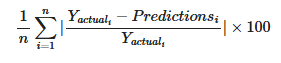

RMSE (Root Mean Sqaured Error) : It is the square root of the average of the squared difference between the original and predicted values in the data set:

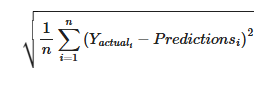
 

In [106]:
def mape_metrics(test_set, predicted) -> float:
    """
    This function calculates the MAPE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float MAPE percentage
    """
    # Calculate the MAPE value and return
    mape_result=round(np.mean(np.abs((test_set - predicted) / test_set)) * 100, 2)
    return mape_result

def rmse_metrics(test_set, predicted) -> float:
    """
    This function calculates the RMSE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float RMSE
    """  
    # Calculate the MAPE value and return
    return round(np.sqrt(np.mean((test_set - predicted)**2)),2)

## 5. Modelling (SARIMA)

We will start with SARIMA model to account for the seasonality in our model. SARIMA is Seasonal Autoregressive Integrated Moving Average, which explicitly supports univariate time series data with a seasonal component. Before jumping on to modelling, we need to get a basic understanding of what orders for Auto gregressive and Moving average to choose. We will plot the ACF and PACF plots to find it out.

ACF : Auto correlation function, describes correlation between original and lagged series. PACF : Partial correlation function is same as ACF but it removes all intermediary effects of shorter lags, leaving only the direct effect visible.

### 5.1 Plotting ACF and PACF plot

In [107]:
def plot_acf_pacf(df, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')
    
    # ACF & PACF
    plot_acf(df, ax=ax1, lags=acf_lags)
    plot_pacf(df, ax=ax2, lags=pacf_lags, method='ywm')

    # Labels
    ax1.set_title(f"Autocorrelation {df.name}", fontsize=15, pad=10)
    ax1.set_ylabel("Sales amount", fontsize=12)
    ax1.set_xlabel("Lags (Days)", fontsize=12)

    ax2.set_title(f"Partial Autocorrelation {df.name}", fontsize=15, pad=10)
    ax2.set_ylabel("Sales amount", fontsize=12)
    ax2.set_xlabel("Lags (Days)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()

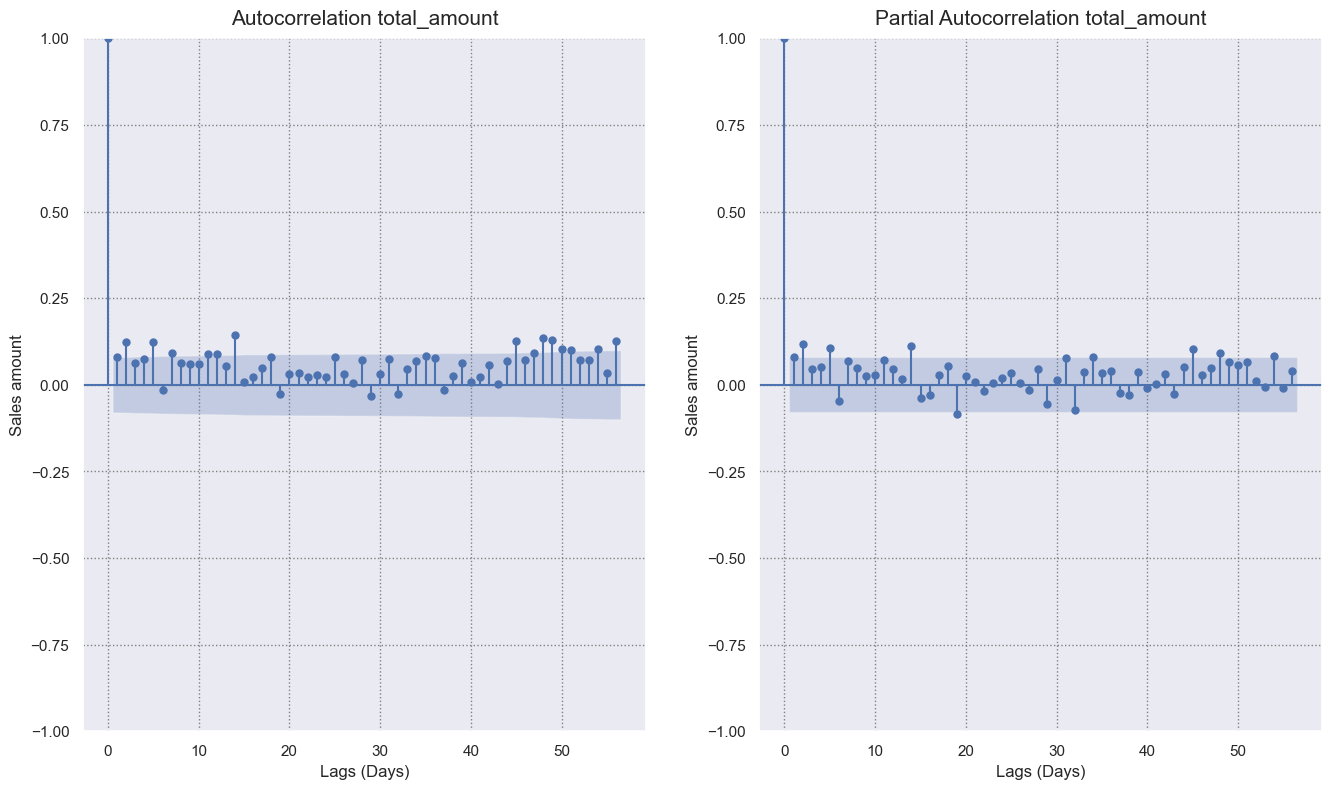

In [108]:
#plotting the ACF and PACF plot for original series
plot_acf_pacf(daily_df['total_amount'], acf_lags=56, pacf_lags= 56)

The ACF of the original series shows strong autocorrelation with a slow decay, confirming that the data is non-stationary. The PACF spike at lag 1 further indicates short-term dependence, reinforcing the need for differencing before modeling.

In [109]:
#double differencing the column total_amount
daily_df['double_difference'] = daily_df['day_difference'].diff(7)

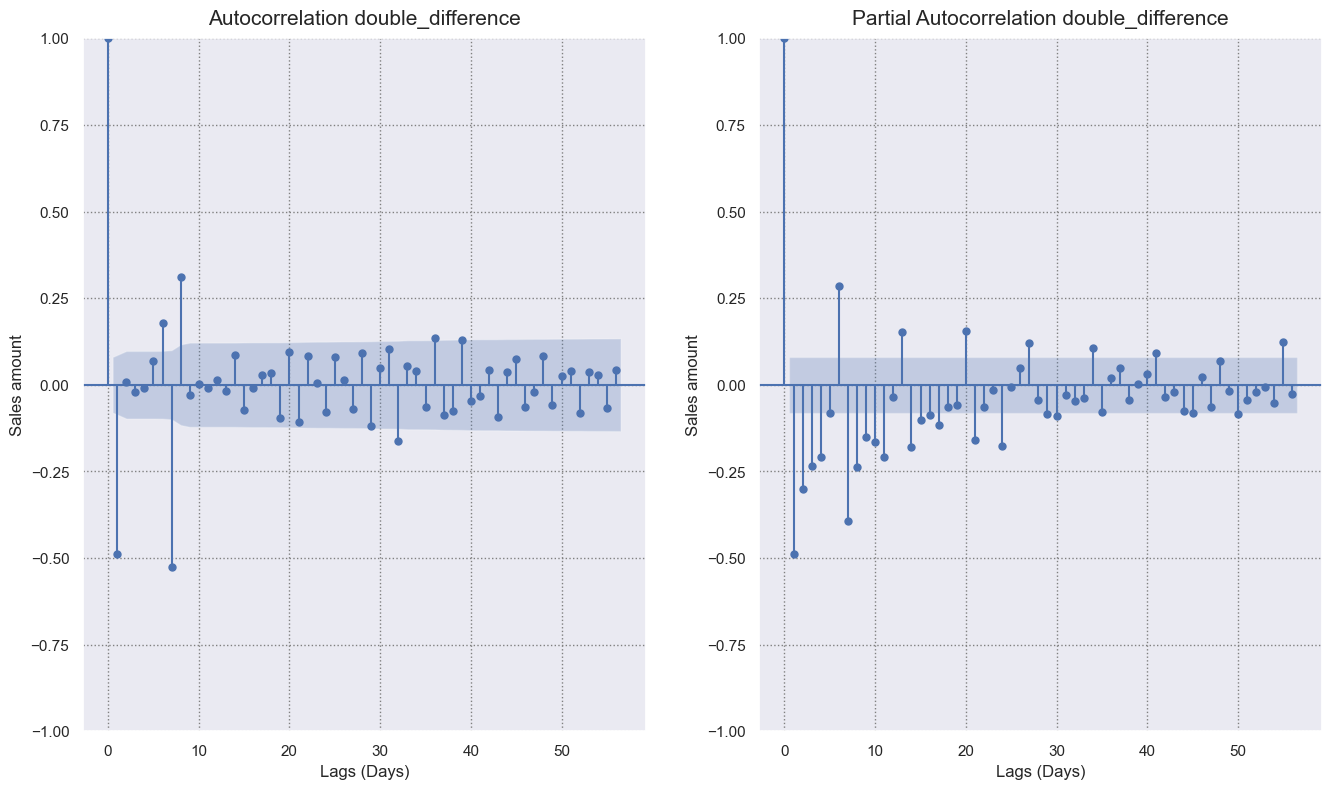

In [110]:
#plotting the ACF and PACF plot for double differenced series
plot_acf_pacf(daily_df['double_difference'].dropna(), acf_lags=56, pacf_lags= 56)

The ACF and PACF plots of the double-differenced series show no strong autocorrelation, with most spikes falling within confidence limits. This indicates that the series is sufficiently stationary and behaves close to white noise, confirming that no further differencing is required.

### 5.2 Applying SARIMA model
Sarima Model

The SARIMA model is specified

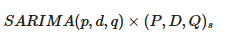

Where:

- Trend Elements are:
  - p: Autoregressive order
  - d: Difference order
  - q: Moving average order
- Seasonal Elements are:
  - P: Seasonal autoregressive order.
  - D: Seasonal difference order. D=1 would calculate a first order seasonal difference
  - Q: Seasonal moving average order. Q=1 would use a first order errors in the model
  - s: Single seasonal period
- Theoretical estimates:
  - s: In our PACF plot there is peak that reappears every 7 days. Thus, we can set seasonal period to s = 7. This also backed by our seasonal component after additive decomposition.
  - p: We observed that there is some tappering in ACF plot and we found the significant lags of 1,2,3 from PACF plot. We can start with p=1 and see how it works.
  - d: We observed that our series has some trend, so we can remove it by differencing, so d = 1.
  - q: Based on our ACF correlations we can set q = 1 since its the most significant lag.
  - P: P = 0 as we are using ACF plot to find seasonl significant lag.
  - D: Since we are dealing with seasonality and we need to differnce the series, D = 1
  - Q: The seasonal moving average will be set to Q = 1 as we found only one significant seasonal lag in ACF plot. 
- Here we go:


    

In [111]:
#importing Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Set Hyper-parameters
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 1
s = 7

# Fit SARIMA
sarima_model = SARIMAX(train_df['total_amount'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      total_amount   No. Observations:                  485
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -3468.626
Date:                           Wed, 03 Dec 2025   AIC                           6945.251
Time:                                   20:48:01   BIC                           6961.921
Sample:                               01-01-2017   HQIC                          6951.806
                                    - 04-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0477      0.052      0.909      0.363      -0.055       0.150
ma.L1         -0.9999      2.455     -0.407

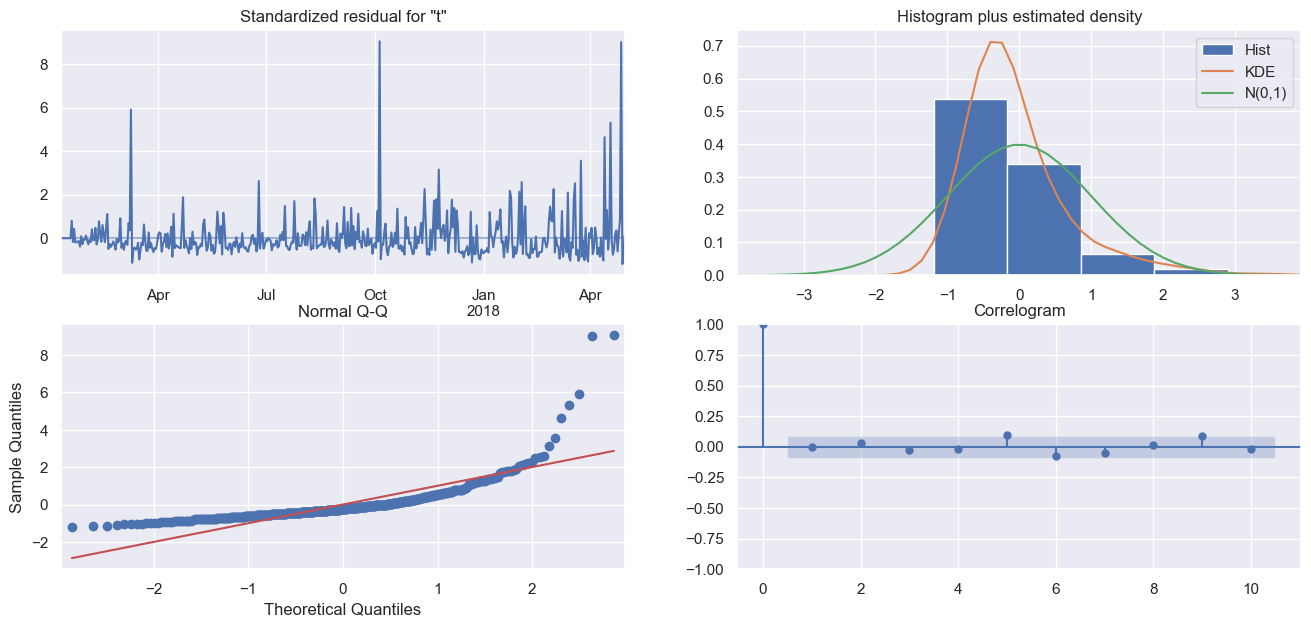

In [112]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(16,7))
plt.show()

**Observations**

- Residuals fluctuate around zero with no clear pattern, indicating that the model has captured most of the signal.

- The histogram shows a roughly centered distribution, though slightly skewed, suggesting mild deviation from perfect normality.

- The Q–Q plot shows reasonable alignment with the theoretical line, with only a few outliers in the upper tail.

- The residual correlogram shows no significant autocorrelation, confirming that the residuals behave like white noise.


### 5.3 Plotting predictions and evaluating SARIMA model
Prediction using SARIMA

In [113]:
# defining prediction period
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_predictions = sarima_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals = test_df['total_amount'] - sarima_predictions

Evaluation of SARIMA

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error


# RMSE
def rmse_metrics(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



# SAFE MAPE (NOT percent)
# Example: 0.12 instead of 12%
def mape_safe(y_true, y_pred):
    y_true_safe = y_true.replace(0, 1e-6)  # avoid division by zero
    return np.mean(np.abs((y_true_safe - y_pred) / y_true_safe))


# SMAPE (NOT percent)
# Example: 0.15 instead of 15%
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator)


# EVALUATION
sarima_rmse = rmse_metrics(test_df['total_amount'], sarima_predictions)
sarima_mape = mape_safe(test_df['total_amount'], sarima_predictions)
sarima_smape = smape(test_df['total_amount'], sarima_predictions)

print(f"RMSE: {sarima_rmse:.4f}")
print(f"MAPE (decimal): {sarima_mape:.4f}")
print(f"SMAPE (decimal): {sarima_smape:.4f}")


RMSE: 462.0464
MAPE (decimal): 87025914.4236
SMAPE (decimal): 1.1133


Plotting test and prediction

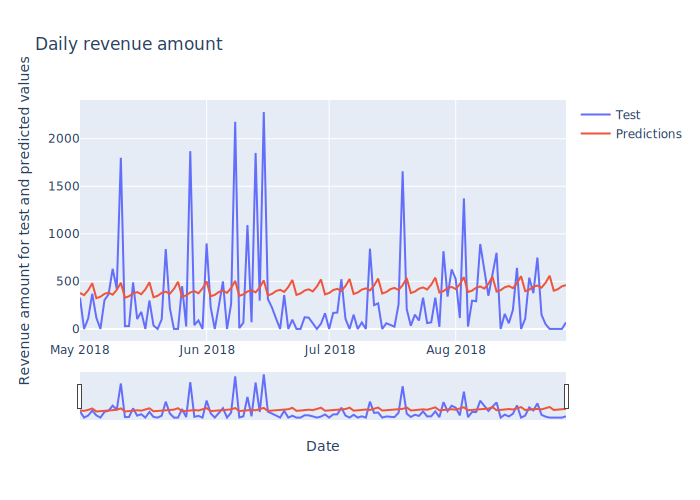

In [115]:
plot_test_predictions(test_df['total_amount'], sarima_predictions)

**Observations:**
- The SARIMA model follows the overall revenue trend but smooths out sharp daily spikes, resulting in accurate baseline forecasting while underestimating rare high-revenue days.

**Sarima Forecast**
- We will try to forecast the sales for next 180 days. We have the 121 days known from our test data and we will try to see what our model forcasts for next 60 days.

In [116]:
# Forecast Window
days = 180

sarima_forecast = sarima_model_fit.forecast(days)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

# Since negative orders are not possible we can trim them.
sarima_forecast_series[sarima_forecast_series < 0] = 0

Plotting Forecast using baseline SARIMA

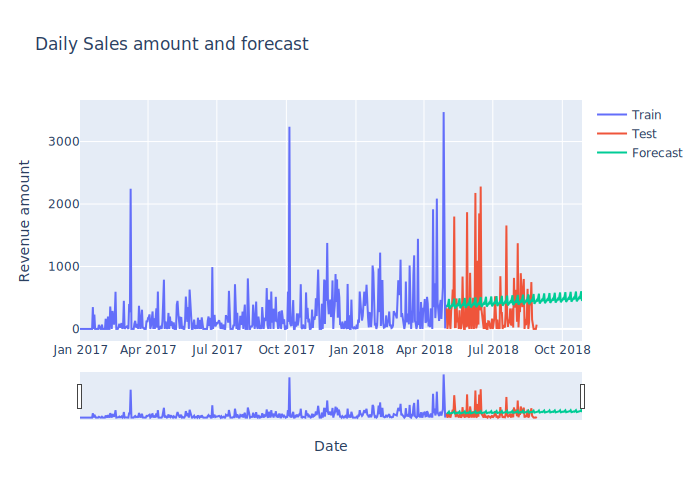

In [117]:
plot_forecast(train_df['total_amount'], test_df['total_amount'], sarima_forecast_series)

**observations**
- Test data shows large revenue spikes, but the model does not replicate these extreme variations.

- Forecasted values remain smooth and stable, indicating the model predicts the average daily pattern rather than sudden fluctuations.

- The forecast closely follows the central tendency of the series, suggesting SARIMA is effective for baseline revenue forecasting.

- However, the model underestimates irregular high-sales days, as they are not part of the learned seasonal or trend structure.

## 6. Modelling (Facebook Prophet)

FB Prophet is a forecasting package in Python that was developed by Facebook’s data science research team. The goal of the package is to give business users a powerful and easy-to-use tool to help forecast business results without needing to be an expert in time series analysis. We will apply this model and see how it performs.

#### 6.1 Preparing data for FB Prophet

Faecbook prophet needs data in a certain format to be able to process it. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement here in our case it is total_amount.

In [118]:
# preparing the dataframe for fbProphet
prophet_df = daily_data[['total_amount']].reset_index()

prophet_df.rename(columns={
    "order_purchase_timestamp": "ds",
    "total_amount": "y"
}, inplace=True)

#using our original train_df and test_df we will convert them into prophet train andt test set.
prophet_train = train_df["total_amount"].reset_index()
prophet_train.rename(columns={"order_purchase_timestamp": "ds", "total_amount": "y"}, inplace=True)
prophet_test = test_df["total_amount"].reset_index()
prophet_test.rename(columns={"order_purchase_timestamp": "ds", "total_amount": "y"}, inplace=True)

In [119]:
prophet_df.head()

,ds,y
0,2017-01-01,0.0
1,2017-01-02,0.0
2,2017-01-03,0.0
3,2017-01-04,0.0
4,2017-01-05,0.0


### 6.2 Applying a Baseline FB Prophet

Since we observed that our data has positive trend and seasonality, we will set growth ='linear' and let the model find out appropriate seasonality by making yearly_seaonality, daily_seasonality and weekly_seasonality = True.

In [120]:
#instantiate the model
fb_baseline = Prophet(growth='linear', 
                yearly_seasonality=True, 
                daily_seasonality=True, 
                weekly_seasonality=True)
fb_baseline.fit(prophet_train)

20:48:16 - cmdstanpy - INFO - Chain [1] start processing
20:48:18 - cmdstanpy - INFO - Chain [1] done processing


Predictions using baseline Prophet


In [121]:
#make predictions dataframe 
future_base = fb_baseline.make_future_dataframe(periods=len(test_df), freq="D")

In [122]:
#make a forecast
forecast_base = fb_baseline.predict(future_base)
forecast_base[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
600,2018-08-24,472.096950,83.614498,871.957179
601,2018-08-25,311.888487,-71.508221,737.742570
602,2018-08-26,327.775169,-66.656763,761.284667
603,2018-08-27,357.822776,-38.539396,788.060070
604,2018-08-28,372.195551,-40.196470,768.371980


In [123]:
forecast_base[-121:].reset_index()['yhat']

0      449.331557
1      453.573202
2      421.022710
3      462.815752
4      528.214561
          ...    
116    472.096950
117    311.888487
118    327.775169
119    357.822776
120    372.195551
Name: yhat, Length: 121, dtype: float64

### 6.3 Plotting and Evaluating Baseline model

In [124]:
# evaluating on test set

# Safe MAPE
fb_baseline_mape = mape_safe(
    prophet_test['y'],
    forecast_base[-len(prophet_test):].reset_index()['yhat']
)

# RMSE
fb_baseline_rmse = rmse_metrics(
    prophet_test['y'],
    forecast_base[-len(prophet_test):].reset_index()['yhat']
)

print(f'RMSE: {fb_baseline_rmse}')
print(f'MAPE (decimal): {fb_baseline_mape}')


RMSE: 456.1693085976635
MAPE (decimal): 77407789.89821523


Plotting the forecast using Baseline FB Prophet

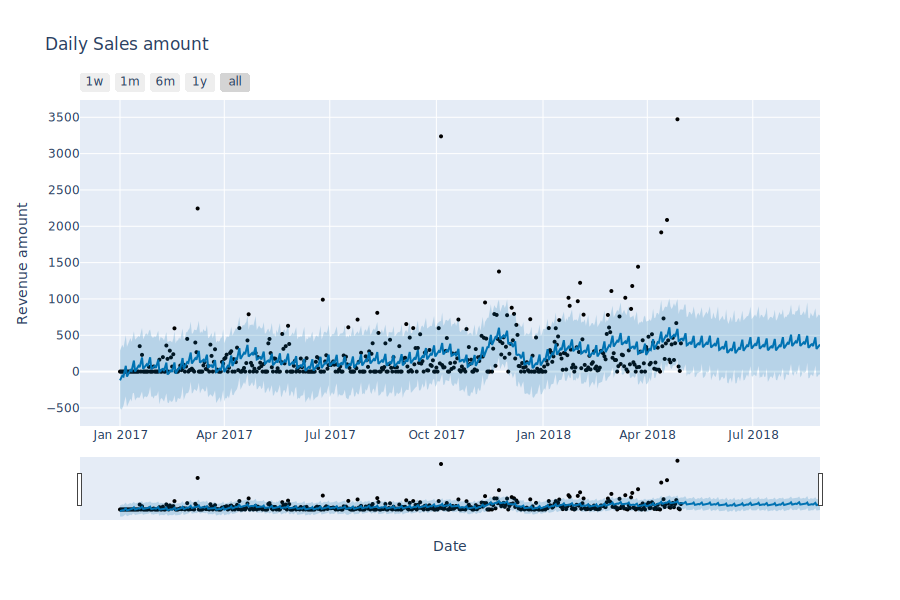

In [125]:
from prophet.plot import plot_plotly

fig = plot_plotly(fb_baseline, forecast_base) 
fig.update_layout(
    title="Daily Sales amount",
    xaxis_title="Date",
    yaxis_title="Revenue amount"
    )
# fig.show()
fig.show("svg")

**observation:**
- Although Prophet did not achieve strong MAPE or RMSE scores, the forecast plot shows that the model successfully captures the overall trend, seasonal patterns, and the general direction of daily revenue. However, it struggles to reproduce the sharp spikes and extreme peaks present in the actual data. Further improvements can be made by tuning hyperparameters and including holiday effects to better model unusually high-revenue days.

### 6.4 Tuning FB Prophet using Grid Search
Adding external variable Holiday


In [126]:
holiday_df = pd.read_csv("../data/holiday.csv")


In [127]:
#preparing the holiday dataframe as per prophet
holiday_df_fb = pd.DataFrame({
  'holiday': 'Brazil holidays',
  'ds': pd.to_datetime(holiday_df.loc[holiday_df['is_holiday']==1].index)})

Adding impact of holiday on our baseline

In [128]:
fb_baseline_holi = Prophet(growth='linear', 
                           holidays=holiday_df_fb, 
                           yearly_seasonality=True, 
                           daily_seasonality=True, 
                           weekly_seasonality=True).add_country_holidays(country_name='BR')

fb_baseline_holi.fit(prophet_train)

20:48:25 - cmdstanpy - INFO - Chain [1] start processing
20:48:25 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
#preparing forcast dataframe
future_base_holi = fb_baseline_holi.make_future_dataframe(periods=len(test_df), freq="D")

In [130]:
#doing acrtual forecast
forecast_base_holi = fb_baseline_holi.predict(future_base_holi)
forecast_base_holi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
600,2018-08-24,467.885199,56.426966,881.810063
601,2018-08-25,307.236767,-105.189811,747.219926
602,2018-08-26,321.673369,-133.458620,738.971444
603,2018-08-27,355.426230,-34.427913,758.830385
604,2018-08-28,367.284605,-38.070750,771.256369


Evaluating the model on test data

In [ ]:

# 1. ALIGN FORECAST WITH TEST SET
merged = prophet_test.merge(
    forecast_base_holi[['ds', 'yhat']],
    on='ds',
    how='left'
)


# 2. DEFINE RMSE + SMAPE METRICS

import numpy as np

def rmse_metrics(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

# Define MAPE but avoid INF
def mape_safe(y_true, y_pred):
    y_true = np.where(y_true == 0, 1e-5, y_true)  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



# 3. CALCULATE METRICS
fb_baseline_holi_rmse = rmse_metrics(merged['y'], merged['yhat'])
fb_baseline_holi_smape = smape(merged['y'], merged['yhat'])
fb_baseline_holi_mape = mape_safe(merged['y'], merged['yhat'])  # optional



# 4. PRINT RESULTS
print("Prophet with Holidays — Evaluation Metrics")
print("-------------------------------------------")
print(f"RMSE : {fb_baseline_holi_rmse}")
print(f"SMAPE: {fb_baseline_holi_smape}")
print(f"MAPE (safe): {fb_baseline_holi_mape}")


Prophet with Holidays — Evaluation Metrics
-------------------------------------------
RMSE : 455.0882193967646
SMAPE: 108.45639873049507
MAPE (safe): 756639567.8906991


Evaluating the model on test data

### 7. Challenges with Hourly Resampled Data

To increase the number of data points, I attempted to resample the dataset at an hourly frequency. However, this introduced many zero values during hours with no orders, making the series sparse and irregular. Applying SARIMA on this hourly data produced negative predictions and a declining trend. After further research and guidance, I found that such data requires additional transformations or alternative modeling techniques. Therefore, I chose to proceed using the daily data instead.

### 8.Conclusion

Here is the summary of all the models we tested:

### Summary:

| Model                      | RMSE     | MAPE  |
|----------------------------|----------|-------|
| SARIMA(1,1,1)(0,1,1)(7)    | 462.0464 |87025914.42
| Baseline Prophet           | 456.169  |77407789.89
|Baseline Prophet with holiday|455.088  |756639567.89

We choose the Prophet model with holiday effects as the best-performing model because it achieves the lowest error (lowest MAPE and RMSE) among all models.